# Problem Statement

Given an inverted Pendulum of length=1, mass=1, design a controller
so that the damping ratio, $\zeta=0.707$, and the 2\% settling time, $t_s=4$ seconds.

In [1]:
import control
import sympy
import sympy.physics.mechanics as mech
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mech.init_vprinting()

In [2]:
# symbols
theta, Q, T = mech.dynamicsymbols('theta, Q, T')
m, l, g, t = sympy.symbols('m, l, g, t')

# frames
frame_e = mech.ReferenceFrame('e')
frame_p = frame_e.orientnew('p', 'Axis', (theta, frame_e.z))
#frame_p.set_ang_vel(frame_e, Q*frame_e.z)

# points
point_a = mech.Point('a')
point_a.set_vel(frame_e, 0)
point_p = point_a.locatenew('p', l*frame_p.x)
point_p.v2pt_theory(point_a, frame_e, frame_p)

# bodies
pendulum = mech.Particle('pendulum', point_p, m)
bodies = [pendulum]

# forces/moments
loads = [
    (point_p, -m*g*frame_e.x),
    (frame_p, T*frame_e.z - 0*Q*frame_e.z)
]


KM = mech.KanesMethod(frame=frame_e, q_ind=[theta], u_ind=[Q], kd_eqs=[theta.diff(t) - Q])
KM.kanes_equations(bodies, loads)

⎛                    ⎡  2     ⎤⎞
⎝[g⋅l⋅m⋅sin(θ) + T], ⎣-l ⋅m⋅Q̇⎦⎠

In [3]:
KM.rhs()

⎡       Q        ⎤
⎢                ⎥
⎢g⋅l⋅m⋅sin(θ) + T⎥
⎢────────────────⎥
⎢       2        ⎥
⎣      l ⋅m      ⎦

In [4]:
KM.linearize(A_and_B=True)

⎛               ⎡ 0  ⎤     ⎞
⎜⎡   0      1⎤  ⎢    ⎥     ⎟
⎜⎢           ⎥  ⎢ 1  ⎥     ⎟
⎜⎢g⋅cos(θ)   ⎥, ⎢────⎥, [T]⎟
⎜⎢────────  0⎥  ⎢ 2  ⎥     ⎟
⎝⎣   l       ⎦  ⎣l ⋅m⎦     ⎠

In [5]:
op_point={m: 1, l: 1, g:9.8, theta: 0, Q: 0}
op_point

In [6]:
A, B, u = KM.linearize(A_and_B=True, op_point=op_point)
A, B, u

⎛⎡ 0   1⎤  ⎡0⎤     ⎞
⎜⎢      ⎥, ⎢ ⎥, [T]⎟
⎝⎣9.8  0⎦  ⎣1⎦     ⎠

In [7]:
C = np.eye(2)
D = np.zeros((2, 1))
G_simo = control.ss2tf(A, B, C, D)
G_simo


Input 1 to output 1:
    1
---------
s^2 - 9.8

Input 1 to output 2:
    s
---------
s^2 - 9.8

In [8]:
G = G_simo[0, 0]
G


    1
---------
s^2 - 9.8

In [9]:
def rlocus(G, kvect=np.logspace(-2, 0, 1000), kwargs={}):
    rlist, klist = control.rlocus(G, kvect=kvect, Plot=False)
    for key in ['rlocus', 'zero', 'pole']:
        if key not in kwargs.keys():
            kwargs[key] = {}

    for z in G.zero():
        plt.plot(np.real(z), np.imag(g), 'o', markeredgewidth=3,  markerfacecolor='none', markersize=20, **kwargs['zero'])

    for z in G.pole():
        plt.plot(np.real(z), np.imag(g), 'x', markeredgewidth=3, markersize=20, **kwargs['pole'])

    for i in range(rlist.shape[1]):
        plt.plot(np.real(rlist[:, i]), np.imag(rlist[:, i]), **kwargs['rlocus'])
    
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

In [10]:
# requirements
zeta = np.sqrt(2)/2
ts = 1

sigma_d = 4/ts
theta = np.arccos(zeta)
wd = sigma_d*np.tan(theta)
sd = -sigma_d + wd*1j
sd

(-4+3.9999999999999996j)

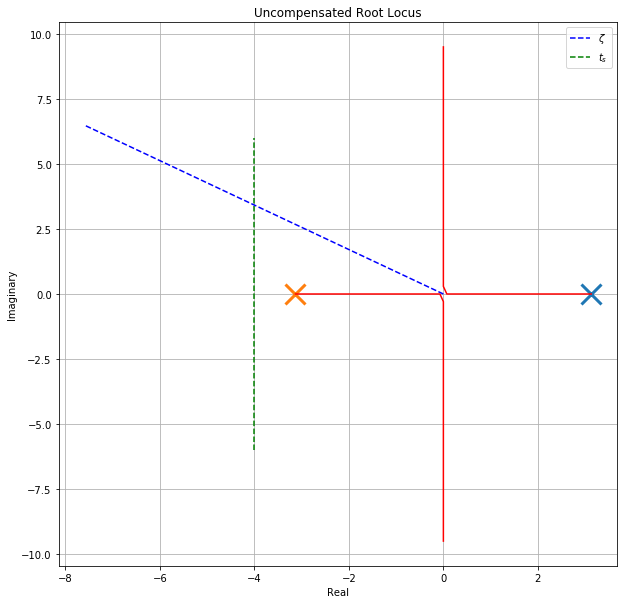

In [11]:
plt.figure(figsize=(10, 10))
rlocus(G, kvect=np.logspace(-2, 2, 1000), kwargs={'rlocus': {'color': 'r'}})
plt.vlines(-sigma_d, -6, 6, color='g', linestyle='--', label='$t_s$')
plt.plot([0, -10*np.cos(zeta)], [0, 10*np.sin(zeta)],  'b--', label='$\zeta$')
plt.grid()
plt.legend()
plt.title('Uncompensated Root Locus');

In [12]:
angle_deficiency = np.pi - np.angle(G(sd))
print('angle deficiency: {:4.1f} deg'.format(np.rad2deg(angle_deficiency)))

angle deficiency: 73.0 deg


In [13]:
s = control.tf([1, 0], [1])
z = -np.imag(sd)/np.tan(angle_deficiency) + np.real(sd)
C = (s-z)
K = 1/np.abs((G*C)(sd))
H = C*K
K, H

(8.0, 
 8 s + 41.8
 ----------
     1)

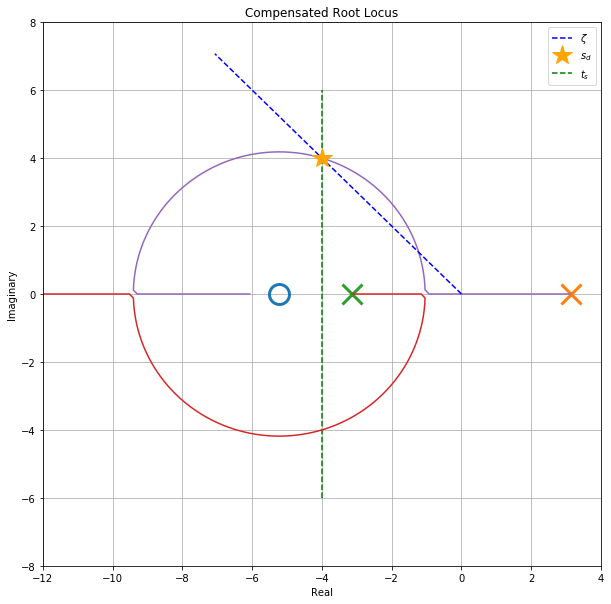

In [14]:
plt.figure(figsize=(10, 10))
rlocus(G*H, kvect=np.linspace(0, 4, 5000))
plt.vlines(-sigma_d, -6, 6, color='g', linestyle='--', label='$t_s$')
plt.plot([0, -10*np.cos(theta)], [0, 10*np.sin(theta)],  'b--', label='$\zeta$')
plt.plot(np.real(sd), np.imag(sd), '*', label='$s_d$', markersize=20, color='orange')
plt.grid()
plt.legend()
plt.axis([-12, 4, -8, 8]);
plt.title('Compensated Root Locus');

In [15]:
L = G*H
Kp = np.real(L(0))
ess = 1/(1 + Kp)
Gc = G*H/(1 + G*H)

To implement this in a real controll system, we would do something like below, where we add a lowpass filter and discretize it at 100 Hz. The lowpass filter is required because the order of the numerator is higher than the order of denominator, so it is not realizable. You should include the low pass filter in your control design normally.

In [16]:
control.c2d(H*50/(s+50), 0.01)


400 z - 383.6
-------------
  z - 0.6065

dt = 0.01

This is the step response of the system, notice that there is a steady state error, to get rid of this, we should have specified a steady state error design requirement. This will require the use of an integrator, which is a full PID controller instead of just a PD controller.

Text(0.5, 1.0, 'unit step response')

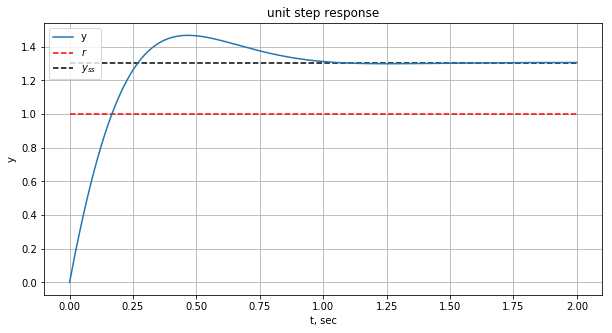

In [17]:
t, y = control.step_response(Gc, np.linspace(0,2, 1000));
plt.figure(figsize=(10, 5))
plt.plot(t, y, label='y')
plt.hlines(1, 0, 2, linestyle='--', color='r', label='$r$')
plt.hlines(1 - ess, 0, 2, linestyle='--', color='k', label='$y_{ss}$')
plt.xlabel('t, sec')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.title('unit step response')